In [1]:
import dask.dataframe as dd
from IPython.display import display
import numpy as np
import pickle
import matplotlib.pyplot as plt
import ast

parquet_file_path = 'SimulationResults/UltimateAnalysis/tau_r/tau_r.parquet'
pickle_file_path = 'SimulationResults/UltimateAnalysis/tau_r/tau_r.pickle'
with open(pickle_file_path, 'rb') as f:
    pickle_data = pickle.load(f)
print("parameter_names_used", pickle_data['parameter_names_used'])
print("param_values_list_combination", pickle_data['param_values_list_combination'])
print('partition_data', pickle_data['agent_type_count'])
print("agent_type", pickle_data['agent_type'])
print("agent_names", pickle_data['agent_names'])

parameter_names_used ['Resources', 'tau_vector', 'r_matrix', 'washout']
param_values_list_combination [[200.0, 250.0, 300.0, 350.0, 400.0, inf], [0.5, 1.06, 1.6199999999999999, 2.1799999999999997, 2.7399999999999998, 3.3, inf], [0.001, 0.0308, 0.0606, 0.09040000000000001, 0.1202, 0.15, inf], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]]
partition_data [3, 2, 8, 3]
agent_type ['Resources', 'Resources', 'Resources', 'Uninfected Bacteria', 'Uninfected Bacteria', 'Infected Bacteria', 'Infected Bacteria', 'Infected Bacteria', 'Infected Bacteria', 'Infected Bacteria', 'Infected Bacteria', 'Infected Bacteria', 'Infected Bacteria', 'Phages', 'Phages', 'Phages']
agent_names ['R0', 'R1', 'R2', 'B0', 'B1', 'Infected B0', 'Infected B1', 'Infected B2', 'Infected B3', 'P0', 'P1', 'P2']


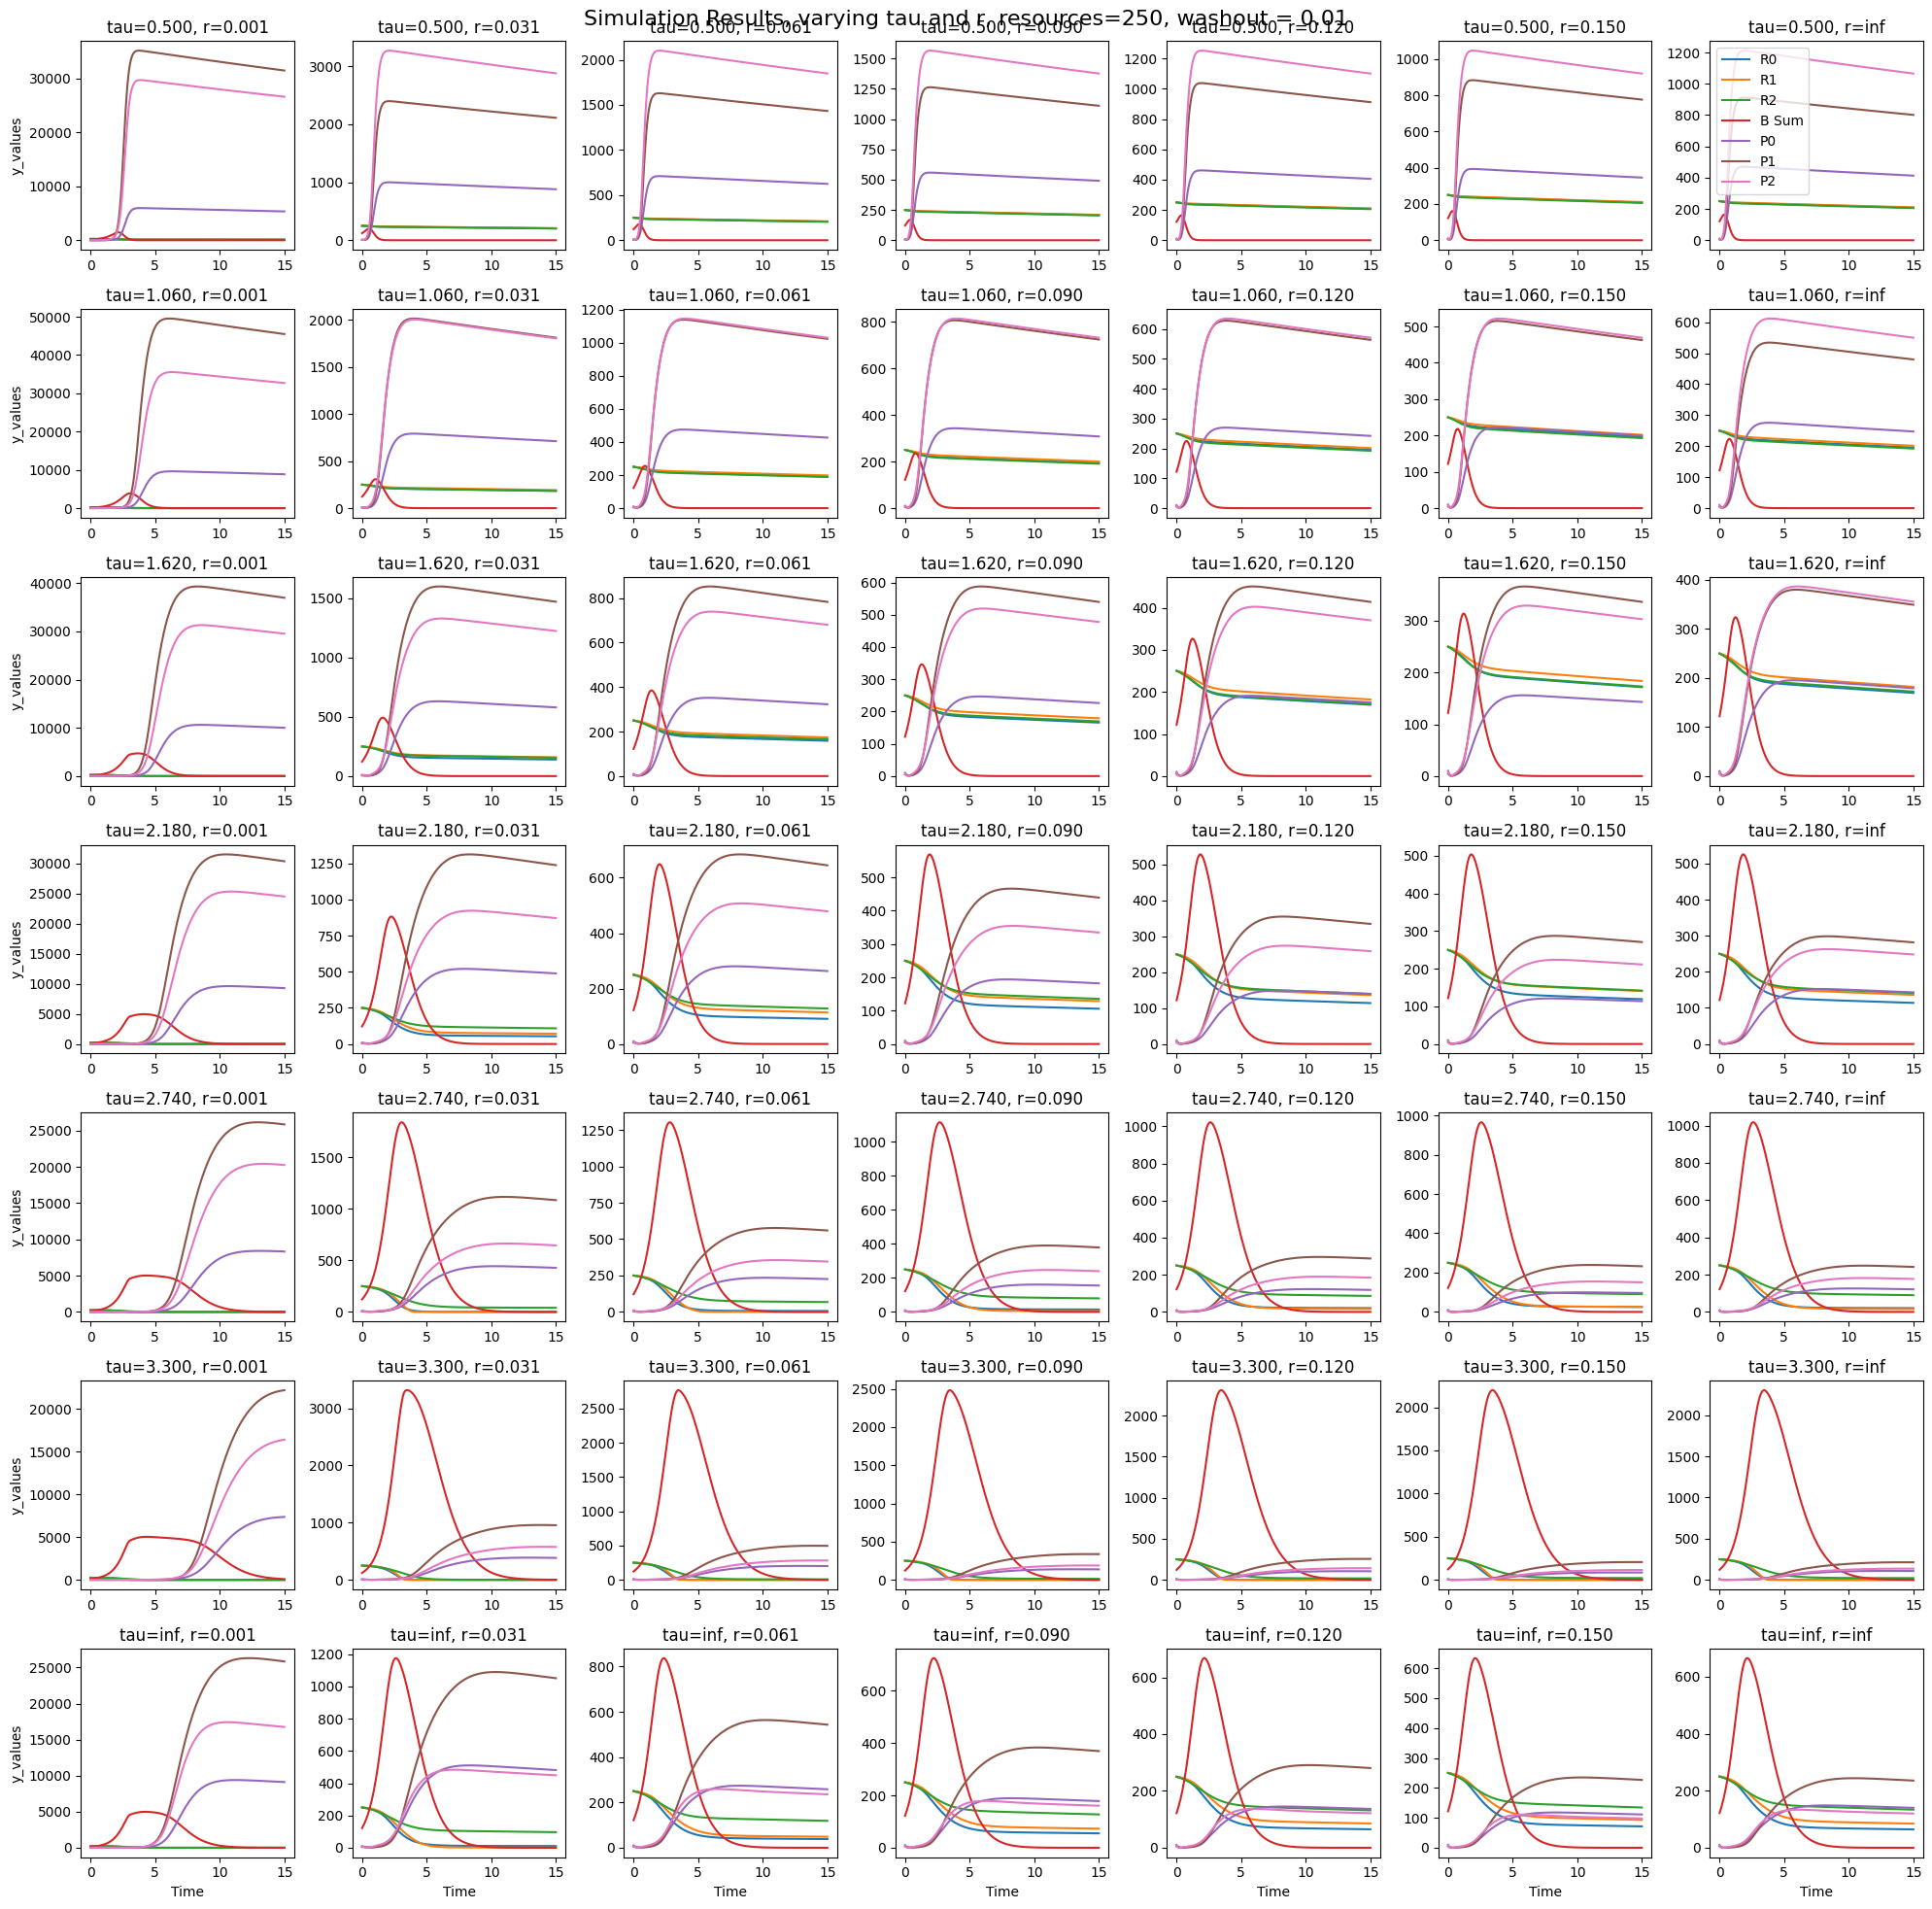

In [2]:
ddf = dd.read_parquet(parquet_file_path, engine='pyarrow', 
                      include_partition_columns=True, 
                      gather_statistics=True, 
                      dtype_backend='pyarrow')

fixed_resources = 250
fixed_washout = 0.01

fig, ax = plt.subplots(7, 7, figsize=(20, 20))
fig.suptitle(f'Simulation Results, varying tau and r, resources={fixed_resources}, washout = {fixed_washout}', fontsize=16)

def bacteria_summary(bacteria):
    return np.sum(bacteria, axis=0)

for i, tau_value in enumerate(pickle_data['param_values_list_combination'][1]):
    for j, r_matrix in enumerate(pickle_data['param_values_list_combination'][2]):
        simulation_results = ddf.query(f'tau_vector == {tau_value} and r_matrix == {r_matrix} and Resources == {fixed_resources} and washout == {fixed_washout}').compute()
        t_values = np.array(ast.literal_eval(simulation_results['t_values'].iloc[0]))
        y_values = np.array(ast.literal_eval(simulation_results['y_values'].iloc[0]))
        ax[i, j].plot(t_values, y_values[0], label=f'R0')
        ax[i, j].plot(t_values, y_values[1], label=f'R1')
        ax[i, j].plot(t_values, y_values[2], label=f'R2')
        
        bac_sum = bacteria_summary(y_values[3:13])
        ax[i, j].plot(t_values, bac_sum, label=f'B Sum')
        
        ax[i, j].plot(t_values, y_values[-3], label=f'P0')
        ax[i, j].plot(t_values, y_values[-2], label=f'P1')
        ax[i, j].plot(t_values, y_values[-1], label=f'P2')
        
        ax[i, j].set_title(f'tau={tau_value:.3f}, r={r_matrix:.3f}')
        if (j == 0):
            ax[i, j].set_ylabel('y_values')
        if (i == 6):
            ax[i, j].set_xlabel('Time')
        if (i == 0 and j == 6):
            ax[i, j].legend()
plt.tight_layout()